In [10]:
import tensorflow as tf
import numpy as np

In [2]:
print(tf.__version__)

2.9.2


In [3]:
(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [4]:
print(x_train_all.shape, y_train_all.shape)

(60000, 28, 28) (60000,)


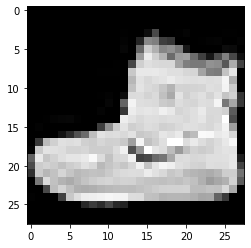

In [5]:
import matplotlib.pyplot as plt
plt.imshow(x_train_all[0], cmap='gray')
plt.show()

In [7]:
print(y_train_all[:10])

[9 0 0 3 0 2 7 2 5 5]


In [8]:
class_names = ['티셔츠/윗도리', '바지', '스웨터', '드레스', '코트', '샌들', '셔츠', '스니커즈', '가방', '앵클부츠']
print(class_names[y_train_all[0]])

앵클부츠


In [11]:
np.bincount(y_train_all)

array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])

In [12]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all,
                                                  test_size=0.2, random_state=42) 

In [15]:
np.bincount(y_train)

array([4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800])

In [14]:
np.bincount(y_val)

array([1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200])

In [16]:
x_train = x_train / 255
x_val = x_val / 255

In [17]:
x_train = x_train.reshape(-1, 784)
x_val = x_val.reshape(-1, 784)
print(x_train.shape, x_val.shape)

(48000, 784) (12000, 784)


In [19]:
tf.keras.utils.to_categorical([0, 1, 3])

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [20]:
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)
print(y_train_encoded.shape, y_val_encoded.shape)

(48000, 10) (12000, 10)


In [21]:
print(y_train[0], y_train_encoded[0])

6 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [23]:
class MultiClassNetwork:
  def __init__(self, units=10, batch_size=32, learning_rate=0.1, l1=0, l2=0):
    self.units = units   # hidden layer의 neuron 개수
    self.batch_size = batch_size  # batch size
    self.w1 = None   # hidden layer의 weight
    self.b1 = None   # hidden layer의 bias
    self.w2 = None   # output layer의 wieght
    self.b2 = None   # output layer의 bias
    self.a1 = None   # hidden layer의 activation 출력
    self.losses = []  # training loss
    self.val_losses = [] # validation loss
    self.lr = learning_rate  # 학습률
    self.l1 = l1   # L1 loss hyperparameter
    self.l2 = l2   # L2 loss hyperparameter


  def forpass(self, x):
    z1 = np.dot(x, self.w1) + self.b1   # 첫 번째 layer의 선형식 계산
    self.a1 = self.sigmoid(z1)   # activation func 적용
    z2 = np.dot(self.a1, self.w2) + self.b2   # 두 번째 layer의 선형식 계산
    return z2


  def backprop(self, x, err):
    m = len(x)   # sample 개수

    # output layer의 weight와 bias에 대한 gradient 계산
    w2_grad = np.dot(self.a1.T, err) / m
    b2_grad = np.sum(err) / m

    # sigmoid 함수까지 gradient 계산
    err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1)  # sigmoid 미분하면 sigmoid(x)(1- sigmoid(x))

    # hidden layer의 wieght와 bias에 대한 gradient 계산
    w1_grad = np.dot(x.T, err_to_hidden) / m
    b1_grad = np.sum(err_to_hidden, axis=0) / m
    b1_grad = np.sum(err_to_hidden, axis=0) / m
    return w1_grad, b1_grad, w2_grad, b2_grad

  def sigmoid(self, z):
    z = np.clip(z, -100, None)  # 안전한 np.exp() 계산을 위해
    a = 1 / (1 + np.exp(-z))
    return a

  def softmax(self, z):
    z = np.clip(z, -100, None) # 안전한 np.exp() 계산을 위해
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z, axis=1).reshape(-1, 1)

  def init_weights(self, n_features, n_classes):
    self.w1 = np.random.normal(0, 1, (n_features, self.units))  # (feature 개수, hidden layer의 크기)
    self.b1 = np.zeros(self.units)  # hidden layer 크기
    self.w2 = np.random.normal(0, 1, (self.units, n_classes))  # (hidden layer 크기, class 개수)
    self.b2 = np.zeros(n_classes)

  def fit(self, x, y, epochs=100, x_val=None, y_val=None):
    np.random.seed(42)
    self.init_weights(x.shape[1], y.shape[1])  # hidden layer와 output layer를 초기화
    # epochs만큼 반복
    for i in range(epochs):
      loss = 0
      print('.', end ='')

      # generator func에서 반환한 mini-batch 순환
      for x_batch, y_batch in self.gen_batch(x, y):
        a = self.training(x_batch, y_batch)
        # 안전한 log 계산을 위해 clipping
        a = np.clip(a, 1e-10, 1-1e-10)
        # log loss와 regularizatio loss를 더하여 list에 추가
        loss += np.sum(-y_batch * np.log(a))
        self.losses.append( (loss + self.reg_loss()) / len(x))
        # validation set에 대한 loss 계산
        self.update_val_loss(x_val, y_val)

  def gen_batch(self, x, y):
    length = len(x)
    bins = length // self.batch_size   # mini-batch 횟수
    if length % self.batch_size:
      bins += 1    # 나누어 떨어지지 않을 때

    indexes = np.random.permutation(np.arange(len(x)))   # index를 섞음
    x = x[indexes]
    y = y[indexes]
    for i in range(bins):
      start = self.batch_size * i
      end = self.batch_size * (i + 1)
      yield x[start:end], y[start:end]  # batch_size만큼 slicing하여 반환

  def training(self, x, y):
    m = len(x)      # sample 개수 저장
    z = self.forpass(x)    # forpass 계산 수행
    a = self.softmax(z)    # activation func 적용
    err = -(y - a)   # error 계산

    # error를 backpropagation하여 gradient 계산
    w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)

    # gradient에서 penalty항의 미분값을 뺌
    w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
    w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m

    # hidden layer의 weight와 bias를 업데이트함.
    self.w1 -= self.lr * w1_grad
    self.b1 -= self.lr * b1_grad

    # output layer의 weight와 bias를 업데이트함
    self.w2 -= self.lr * w2_grad
    self.b2 -= self.lr * b2_grad

    return a

  def predict(self, x):
    z = self.forpass(x)   # forpass 계산 수행
    return np.argmax(z, axis=1)   # 가장 큰 값의 index 반환

  def score(self, x, y):
    # prediction과 target vector를 비교해 True의 비율 반환
    return np.mean(self.predict(x) == np.argmax(y, axis=1))

  def reg_loss(self):
    # hidden layer와 output layer의 weight에 regularization 적용
    return self.l1 * (np.sum(np.abs(self.w1) + np.sum(np.abs(self.w2))) + \
                      self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2)))
    
  def update_val_loss(self, x_val, y_val):
    z = self.forpass(x_val)  # forpass 계산 수행
    a = self.softmax(z)  # activation func 적용
    a = np.clip(a, 1e-10, 1-1e-10)   # 출력값을 clipping함
    # cross entropy loss와 regularization loss를 더해 list에 추가

    val_loss = np.sum(-y_val*np.log(a))
    self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))

In [24]:
fc = MultiClassNetwork(units=100, batch_size=256)
fc.fit(x_train, y_train_encoded, x_val=x_val, y_val=y_val_encoded, epochs=40)

........................................

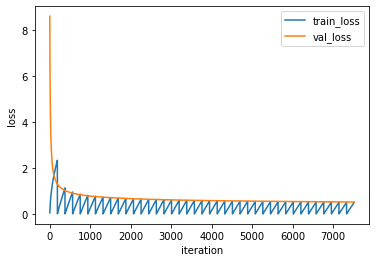

In [25]:
plt.plot(fc.losses)
plt.plot(fc.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [26]:
fc.score(x_val, y_val_encoded)

0.8150833333333334

In [27]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
model = Sequential()

In [28]:
model.add(Dense(100, activation='sigmoid', input_shape=(784,)))
model.add(Dense(10, activation='softmax'))

In [29]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
model = Sequential()

In [30]:
model.add(Dense(100, activation='sigmoid', input_shape=(784,)))
model.add(Dense(10, activation='softmax')) 

In [32]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [33]:
history = model.fit(x_train, y_train_encoded, epochs=40, validation_data=(x_val, y_val_encoded))

Epoch 1/40
1500/1500 [==============================] - 8s 5ms/step - loss: 1.3946 - accuracy: 0.6500 - val_loss: 0.9705 - val_accuracy: 0.7354
Epoch 2/40
1500/1500 [==============================] - 6s 4ms/step - loss: 0.8442 - accuracy: 0.7468 - val_loss: 0.7489 - val_accuracy: 0.7675
Epoch 3/40
1500/1500 [==============================] - 6s 4ms/step - loss: 0.7092 - accuracy: 0.7667 - val_loss: 0.6612 - val_accuracy: 0.7820
Epoch 4/40
1500/1500 [==============================] - 6s 4ms/step - loss: 0.6433 - accuracy: 0.7838 - val_loss: 0.6098 - val_accuracy: 0.7961
Epoch 5/40
1500/1500 [==============================] - 6s 4ms/step - loss: 0.6015 - accuracy: 0.7964 - val_loss: 0.5735 - val_accuracy: 0.8049
Epoch 6/40
1500/1500 [==============================] - 6s 4ms/step - loss: 0.5715 - accuracy: 0.8054 - val_loss: 0.5474 - val_accuracy: 0.8127
Epoch 7/40
1500/1500 [==============================] - 6s 4ms/step - loss: 0.5489 - accuracy: 0.8118 - val_loss: 0.5279 - val_accuracy:

In [34]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


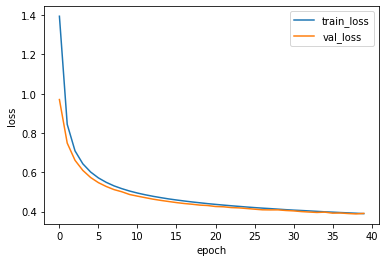

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

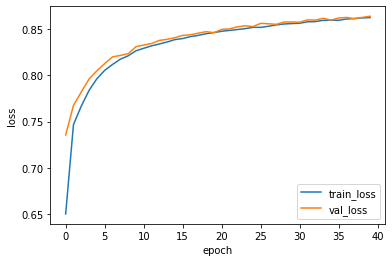

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [37]:
loss, accuracy = model.evaluate(x_val, y_val_encoded, verbose=0)
print(accuracy)

0.8640000224113464
